In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem40.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem26.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/30.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem48.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem37.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem22.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem36.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem1.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem45.jpg
/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/ModerateDemented/moderateDem31.jpg
/kaggle/input/6400alzheimer/6400

In [61]:
!pip install scikit-plot

import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [62]:
class CFG:
    EPOCHS = 30
    BATCH_SIZE = 42
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 448
    CHANNELS = 3
    IMAGE_SIZE = (224, 448, 3)

In [74]:
# Define paths
DATASET_PATH = "/kaggle/input/6400alzheimer/6400_Alzheimer/Alzheimer_s Dataset/"

In [75]:
%%time
dataset_images = glob.glob(f"{DATASET_PATH}**/*.jpg")

CPU times: user 23.7 ms, sys: 1.38 ms, total: 25 ms
Wall time: 26.8 ms


In [76]:
# Get dataset size
total = len(dataset_images)

# View samples counts
print(f'TOTAL: {total}')

TOTAL: 6400


In [77]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [78]:
# Build the Dataset DataFrame
dataset_df = build_df(dataset_images, generate_labels(dataset_images))

In [79]:
# View first 5 samples in the dataset
dataset_df.head(5)

,image_path,label
0,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented
1,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented
2,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented
3,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented
4,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented


In [80]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

,image_path,label,label_encoded
0,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
1,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
2,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
3,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
4,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
5,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
6,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
7,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
8,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
9,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3


In [81]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 4
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


In [82]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

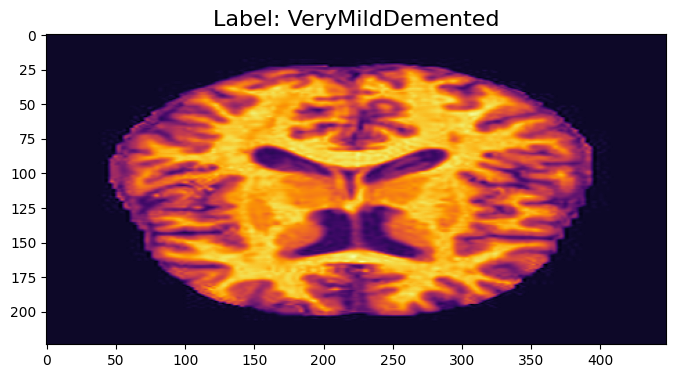

In [83]:
# Select random sample from train_df
idx = random.sample(dataset_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(dataset_df.image_path[idx]), dataset_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')

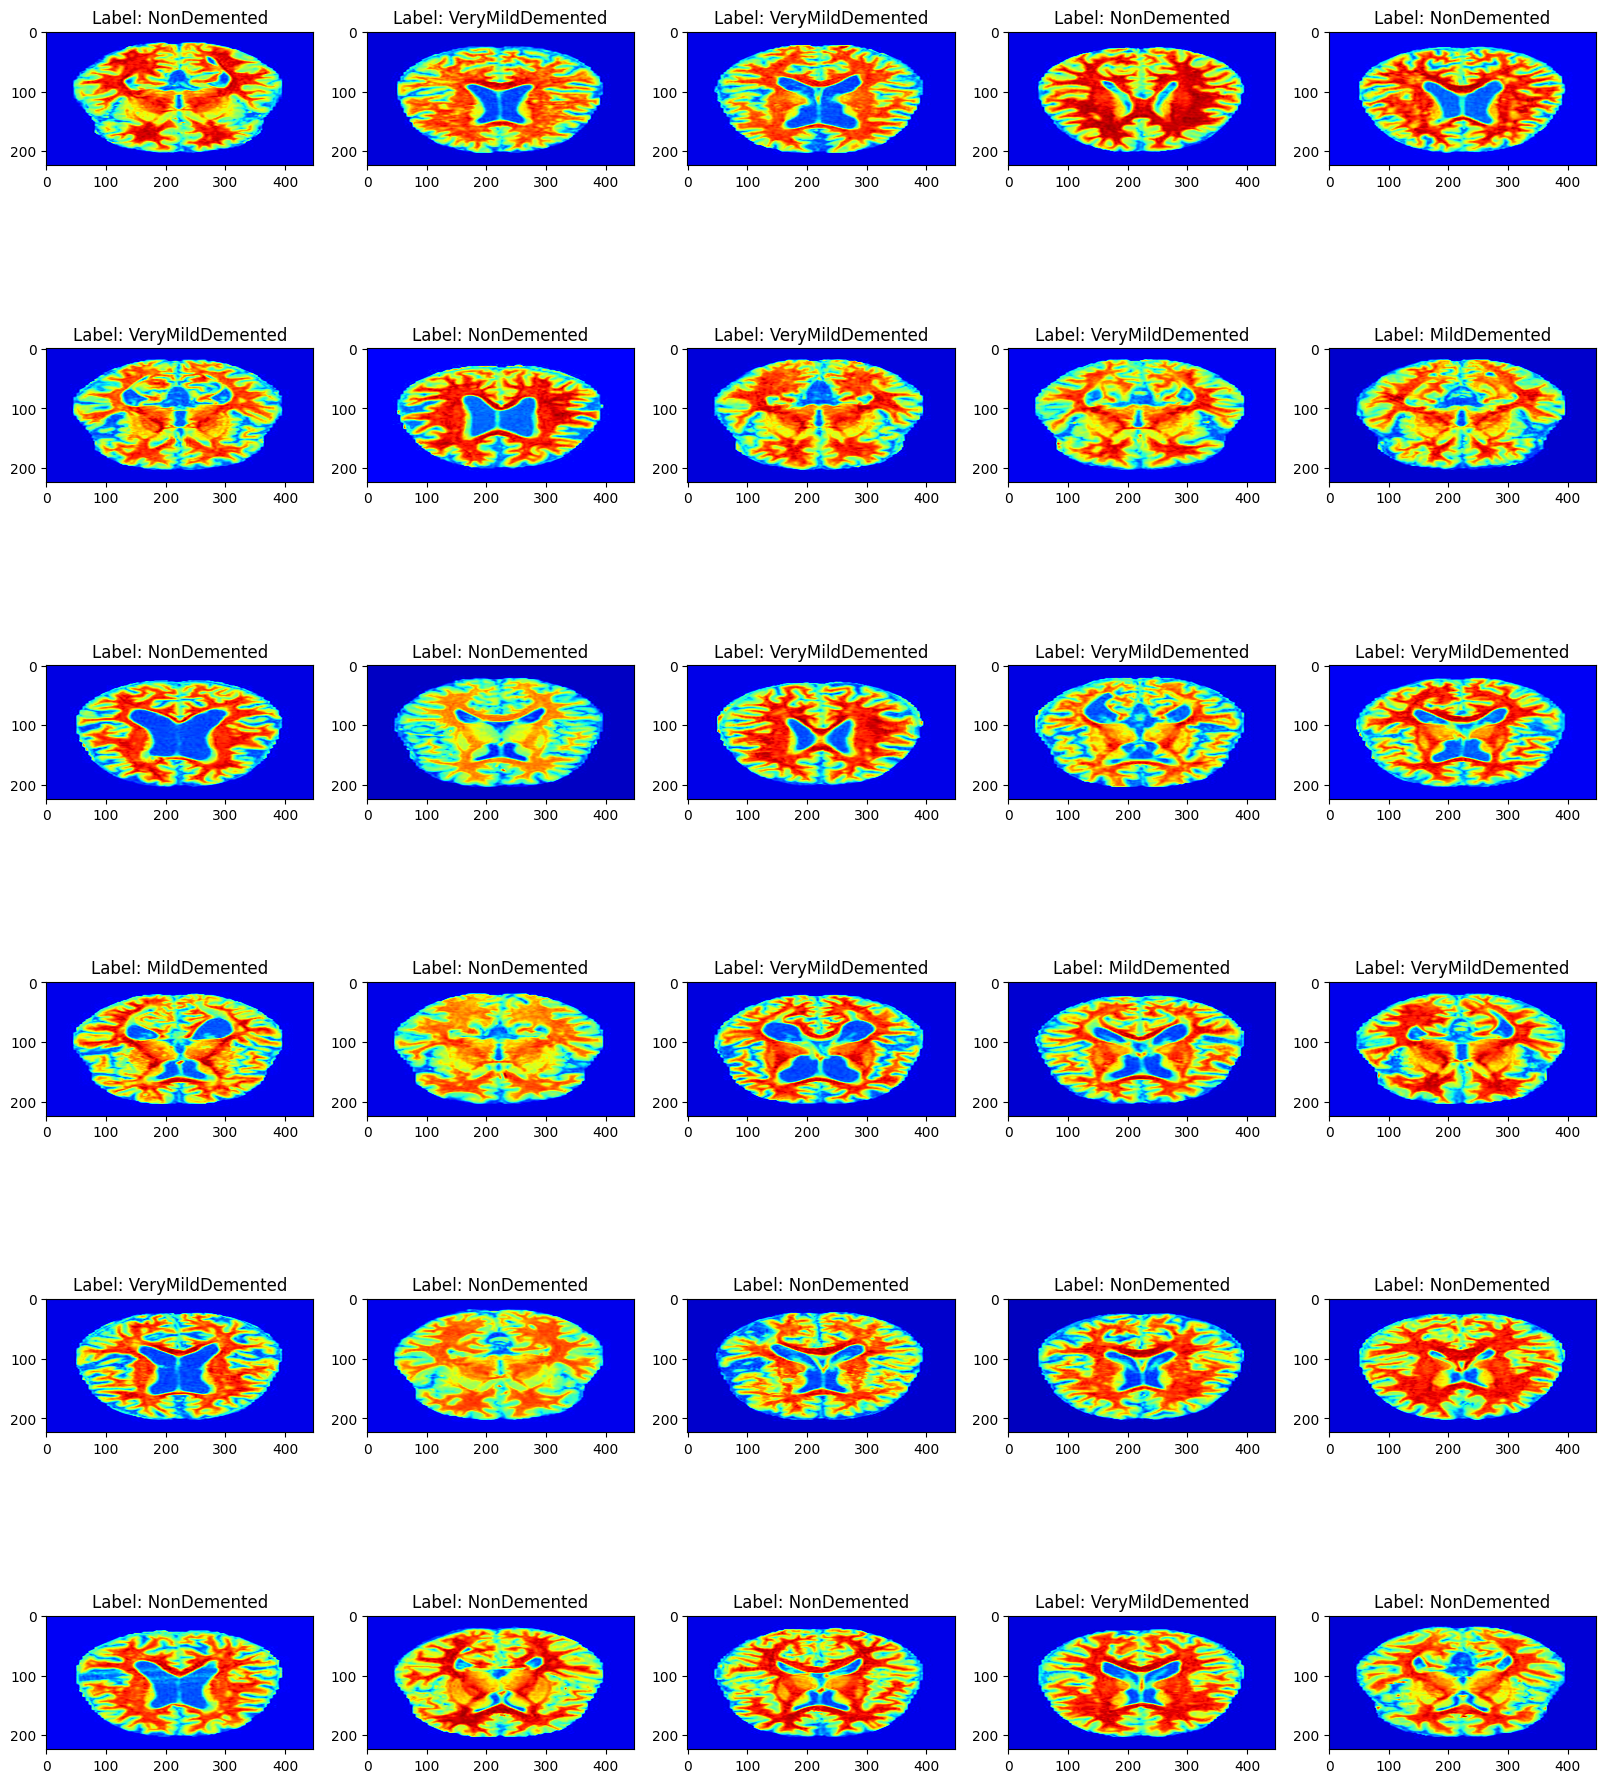

In [84]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='gray', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map);

    return

view_mulitiple_samples(dataset_df, _load,
                       count=30, color_map='jet',
                       fig_size=(20, 24))

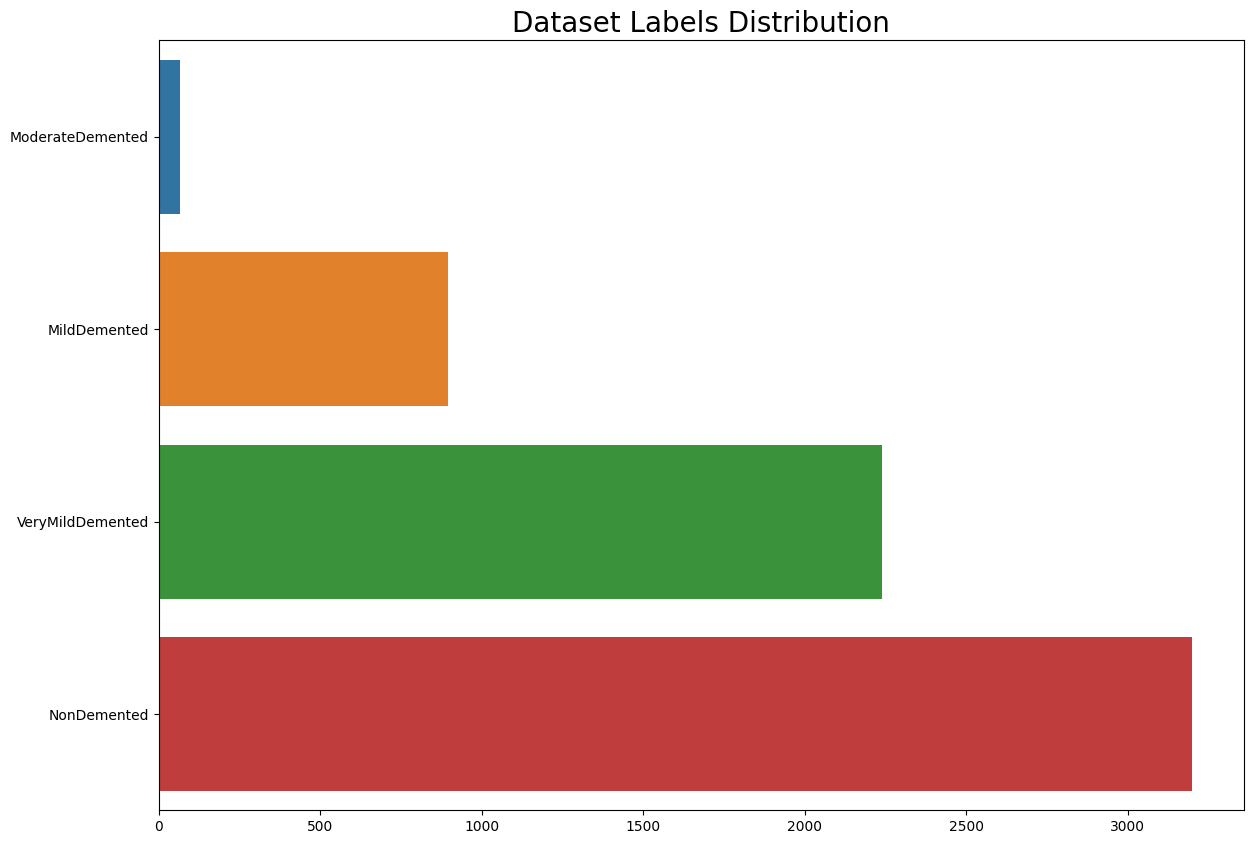

In [85]:
# Generate Figure
fig = plt.figure(figsize=(14, 10))

# Plot Labels Distribution
plt.title('Dataset Labels Distribution', fontsize=20)
distribution = dataset_df['label'].value_counts().sort_values()
sns.barplot(x=distribution.values,
            y=list(distribution.keys()),
            orient="h");

In [86]:
dataset_df['label'].value_counts().sort_values()

label
ModerateDemented      64
MildDemented         896
VeryMildDemented    2240
NonDemented         3200
Name: count, dtype: int64

In [87]:
# Generate Label Encoder
label_encoder = LabelEncoder()

# Label Encode the Image Labels
dataset_df['label_encoded'] = label_encoder.fit_transform(dataset_df.label)

# View first 10 samples
dataset_df.head(10)

,image_path,label,label_encoded
0,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
1,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
2,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
3,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
4,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
5,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
6,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3
7,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
8,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,NonDemented,2
9,/kaggle/input/6400alzheimer/6400_Alzheimer/Alz...,VeryMildDemented,3


In [88]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 4
Classes: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


In [89]:
# Create Train/Test split with Training Set
train_split_idx, val_test_split_idx, _, _ = train_test_split(dataset_df.index,
                                                        dataset_df.label_encoded,
                                                        test_size=0.3,
                                                        stratify=dataset_df.label_encoded,
                                                        random_state=CFG.SEED)

In [90]:
# Get training and validation data
train_df = dataset_df.iloc[train_split_idx].reset_index(drop=True)
val_test_df = dataset_df.iloc[val_test_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, val_test_df.shape

((4480, 3), (1920, 3))

In [91]:
# Create Train/Test split with Training Set
val_split_idx, test_split_idx, _, _ = train_test_split(val_test_df.index,
                                                       val_test_df.label_encoded,
                                                       test_size=2/3,
                                                       stratify=val_test_df.label_encoded,
                                                       random_state=CFG.SEED)

In [92]:
# Get validation and test data
val_df = dataset_df.iloc[val_split_idx].reset_index(drop=True)
test_df = dataset_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((640, 3), (1280, 3))

In [93]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}')
print(f'validation samples count:\t{val_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		4480
validation samples count:	640
test samples count:		1280
TOTAL:				6400


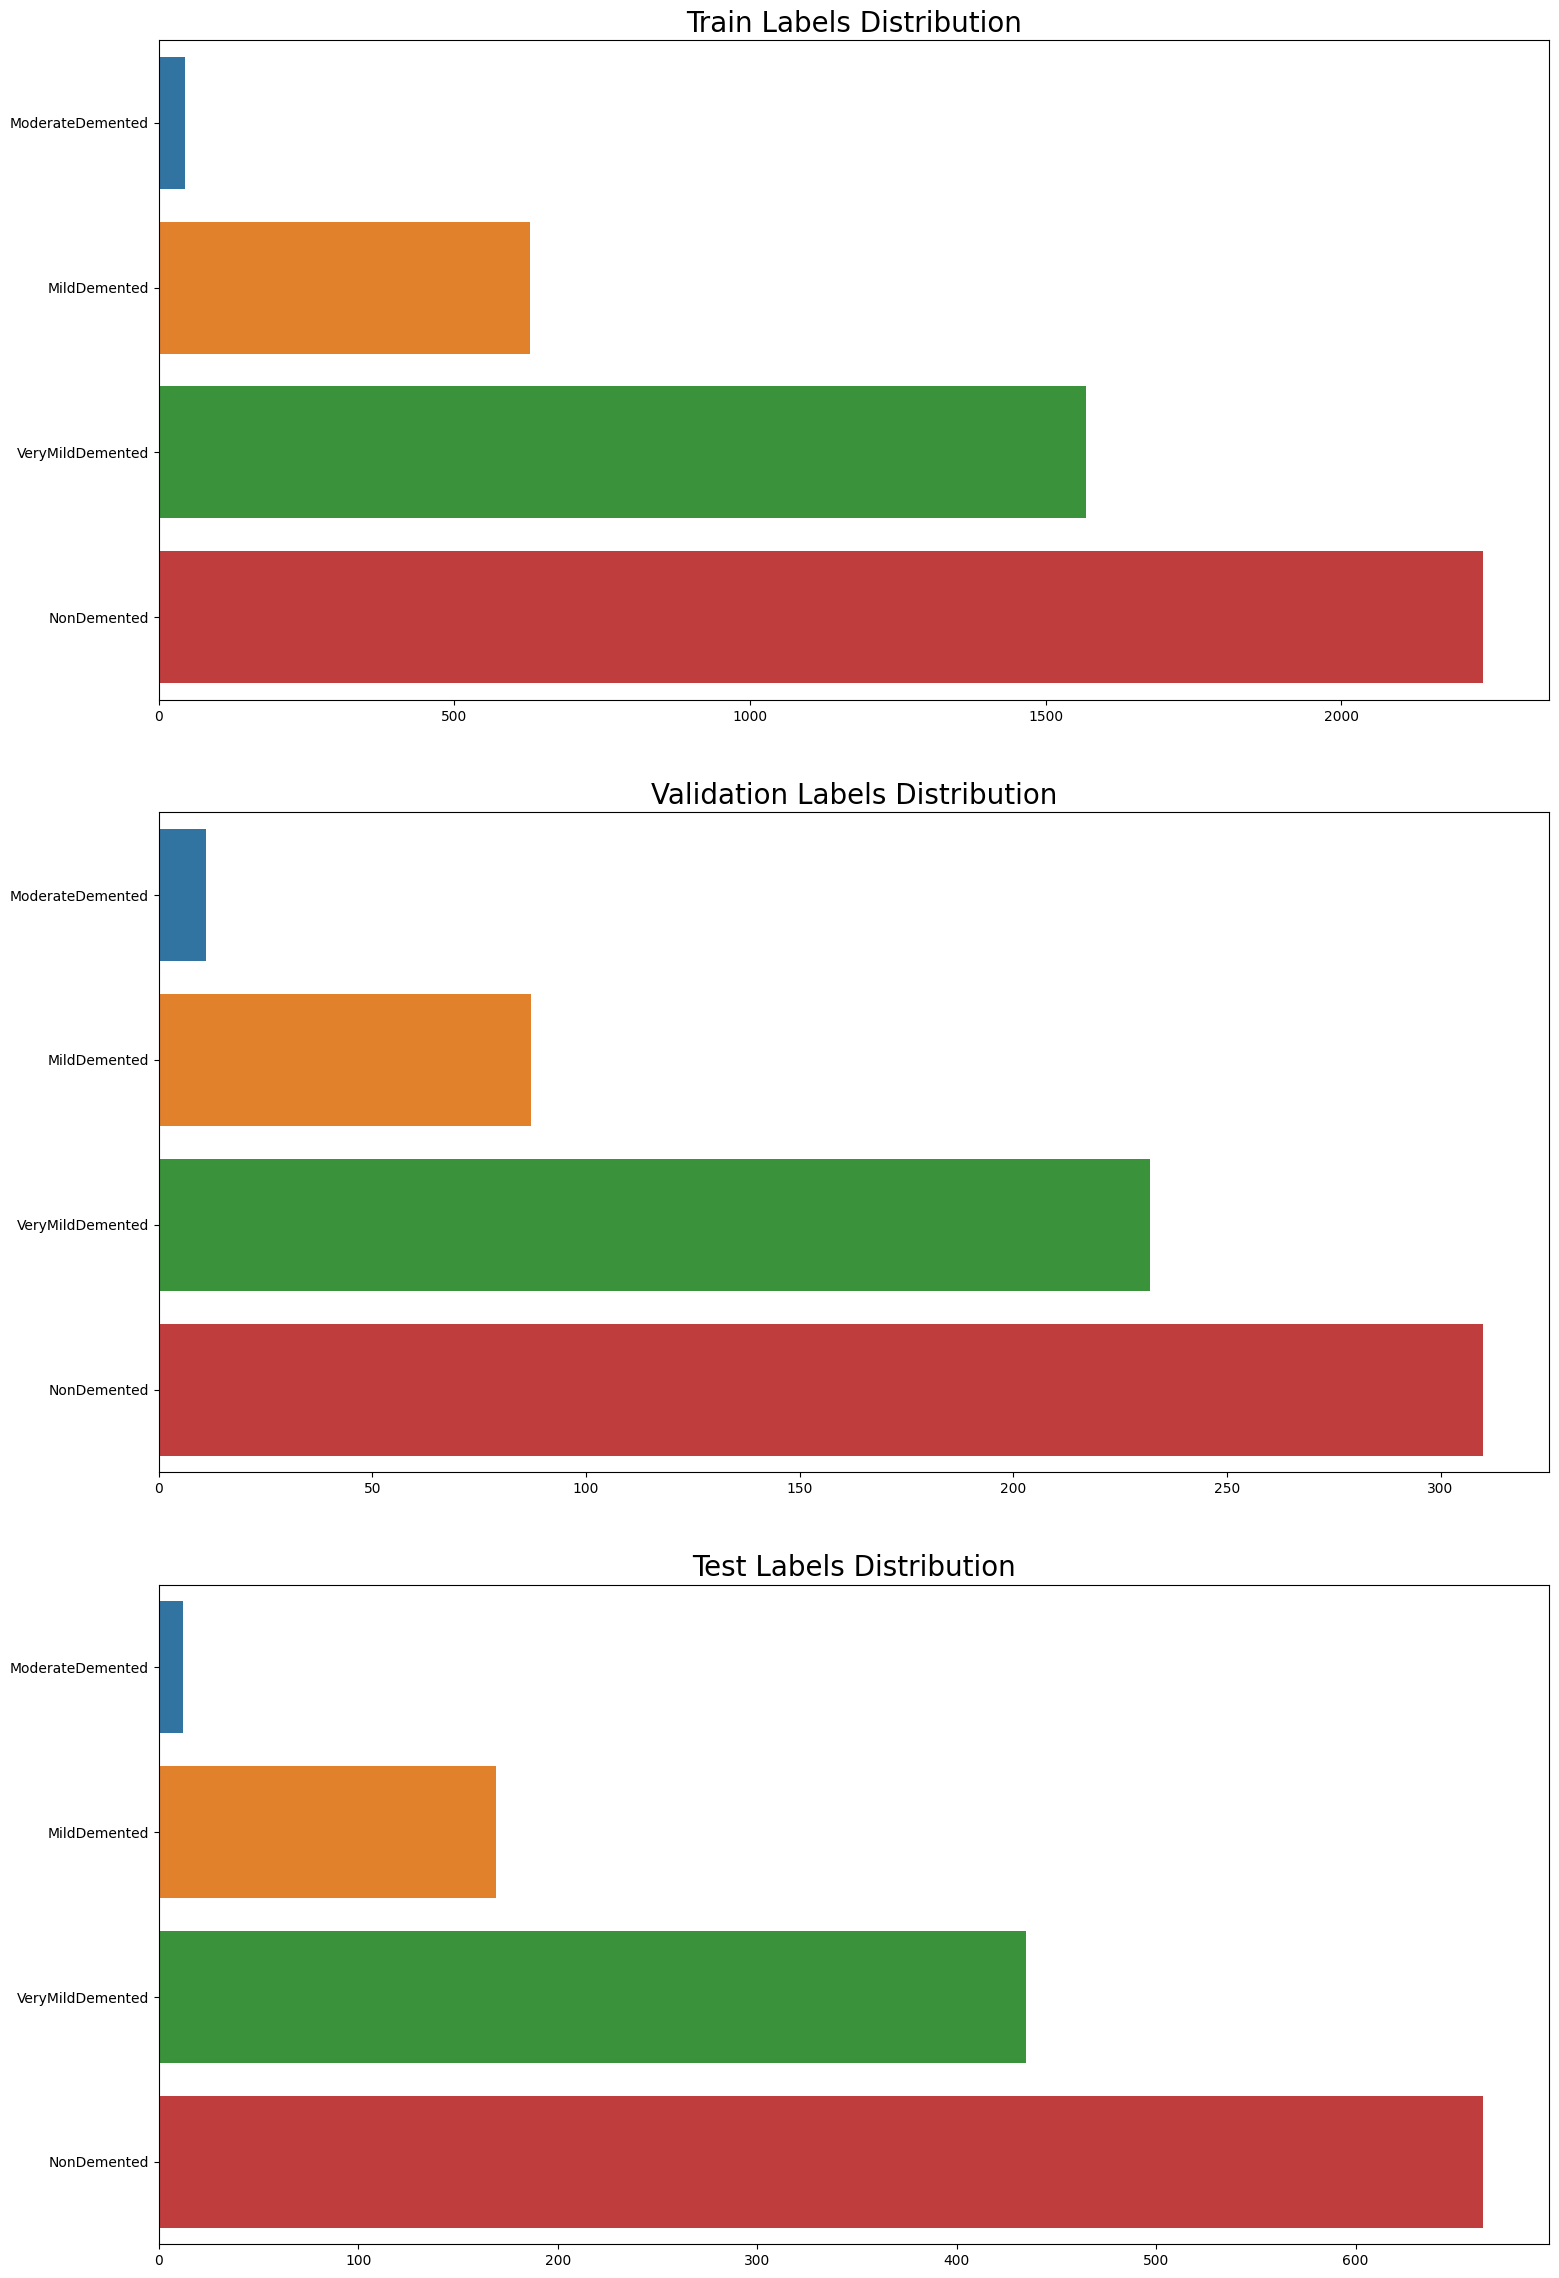

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 24))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

In [95]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

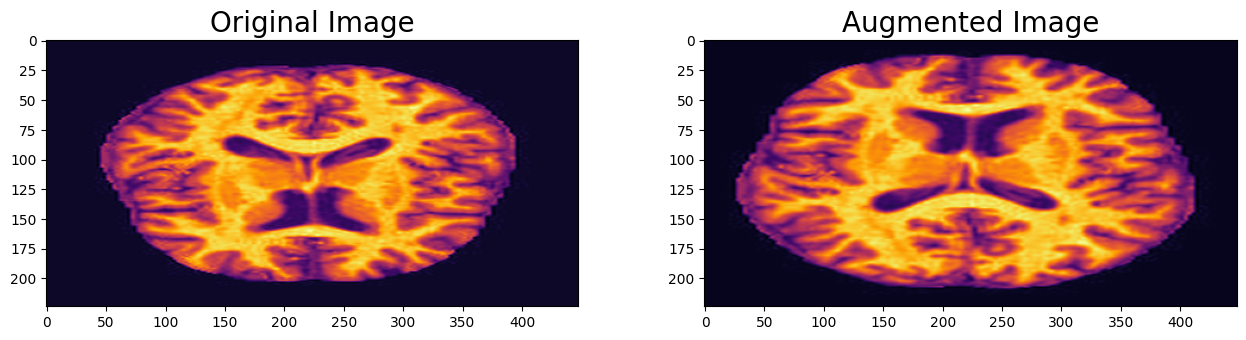

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(tf.image.rgb_to_grayscale(sample_image), cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(tf.image.rgb_to_grayscale(augmentation_layer(sample_image)), cmap='inferno');

In [97]:
def encode_labels(labels, encode_depth=4):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=20, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [98]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_df, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [99]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [100]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=True):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [101]:
def train_model(model, num_epochs, callbacks_list, tf_train_data,
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data.

        @params
        - model: (tf.keras.model) -> model to be trained
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)

        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''

    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)

    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [102]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

In [103]:
# Get EfficientNet V2 B0 here
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2'
model_name = 'efficientnet_v2_b3'

# Set trainable to False for inference-only
set_trainable=True

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url,
                                     model_name,
                                     model_trainable=set_trainable)

In [104]:
def efficientnet_v2_model():

    initializer = tf.keras.initializers.GlorotNormal(seed=CFG.SEED)

    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(512, activation='relu', kernel_initializer=initializer),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(4, dtype=tf.float32, activation='softmax', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')

    return efficientnet_v2_sequential

In [105]:
# Generate Model
model_efficientnet_v2 = efficientnet_v2_model()

# Generate Summary of the Model
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b3 (KerasLa  (None, 1536)             12930622  
 yer)                                                            
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 13,849,922
Trainable params: 13,740,706
Non-trainable params: 109,216
________________

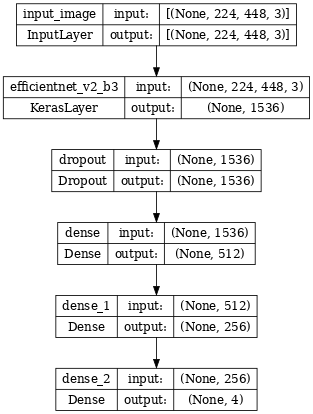

In [106]:
# Explore model visually
plot_model(
    model_efficientnet_v2, dpi=60,
    show_shapes=True
)

In [107]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_efficientnet_v2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_v2_history = train_model(
    model_efficientnet_v2, CFG.EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)

Training efficientnet_v2_sequential_model.
Train on 4480 samples, validate on 640 samples.
----------------------------------
Epoch 1/30
107/107 [==============================] - 184s 906ms/step - loss: 0.9835 - accuracy: 0.5308 - val_loss: 0.9246 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 2/30
107/107 [==============================] - 91s 846ms/step - loss: 0.8559 - accuracy: 0.5897 - val_loss: 0.7820 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 3/30
107/107 [==============================] - 90s 842ms/step - loss: 0.8012 - accuracy: 0.6125 - val_loss: 0.9044 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/30
107/107 [==============================] - 90s 844ms/step - loss: 0.7625 - accuracy: 0.6502 - val_loss: 0.6603 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 5/30
107/107 [==============================] - 90s 843ms/step - loss: 0.7092 - accuracy: 0.6783 - val_loss: 0.6681 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 6/30
107/107 [==============================] - ETA: 0s - loss: 0.6547 - accu

In [108]:
# Evaluate the model
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)

31/31 [==============================] - 7s 223ms/step - loss: 0.1161 - accuracy: 0.9672


In [109]:
# Generate model probabilities and associated predictions
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)

31/31 [==============================] - 7s 182ms/step


In [110]:
import pandas as pd

# Assuming you have trained the model and have the 'efficientnet_v2_history' dictionary

# Extract training and validation metrics from the history dictionary
train_accuracy = efficientnet_v2_history.history['accuracy']
train_loss = efficientnet_v2_history.history['loss']
validation_accuracy = efficientnet_v2_history.history['val_accuracy']
validation_loss = efficientnet_v2_history.history['val_loss']

# Create a DataFrame with the extracted metrics
metrics_df = pd.DataFrame({
    'Train Accuracy': train_accuracy,
    'Train Loss': train_loss,
    'Validation Accuracy': validation_accuracy,
    'Validation Loss': validation_loss
})

# Save the DataFrame to an Excel file
excel_directory = '/kaggle/working//'
excel_filename = 'effmetrics.xlsx'
metrics_df.to_excel(excel_directory + excel_filename, index=False)

print(f"Metrics saved to {excel_directory + excel_filename}.")


Metrics saved to /kaggle/working//effmetrics.xlsx.


In [111]:
print(metrics_df)

    Train Accuracy  Train Loss  Validation Accuracy  Validation Loss
0         0.530804    0.983507             0.518750         0.924623
1         0.589732    0.855888             0.637500         0.782018
2         0.612500    0.801237             0.550000         0.904415
3         0.650223    0.762497             0.696875         0.660297
4         0.678348    0.709222             0.678125         0.668051
5         0.714955    0.654657             0.668750         1.015636
6         0.789286    0.501662             0.840625         0.385056
7         0.837500    0.396323             0.846875         0.369174
8         0.870759    0.323950             0.890625         0.286914
9         0.891295    0.275318             0.895312         0.283109
10        0.906473    0.239403             0.926562         0.199816
11        0.919866    0.200276             0.926562         0.178548
12        0.933259    0.184308             0.935938         0.172502
13        0.937500    0.164533    

In [112]:
model_save_path = 'eff_85k_model.h5'
model_efficientnet_v2.save(model_save_path)

print(f"Model saved to {model_save_path}.")

Model saved to eff_85k_model.h5.


In [113]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

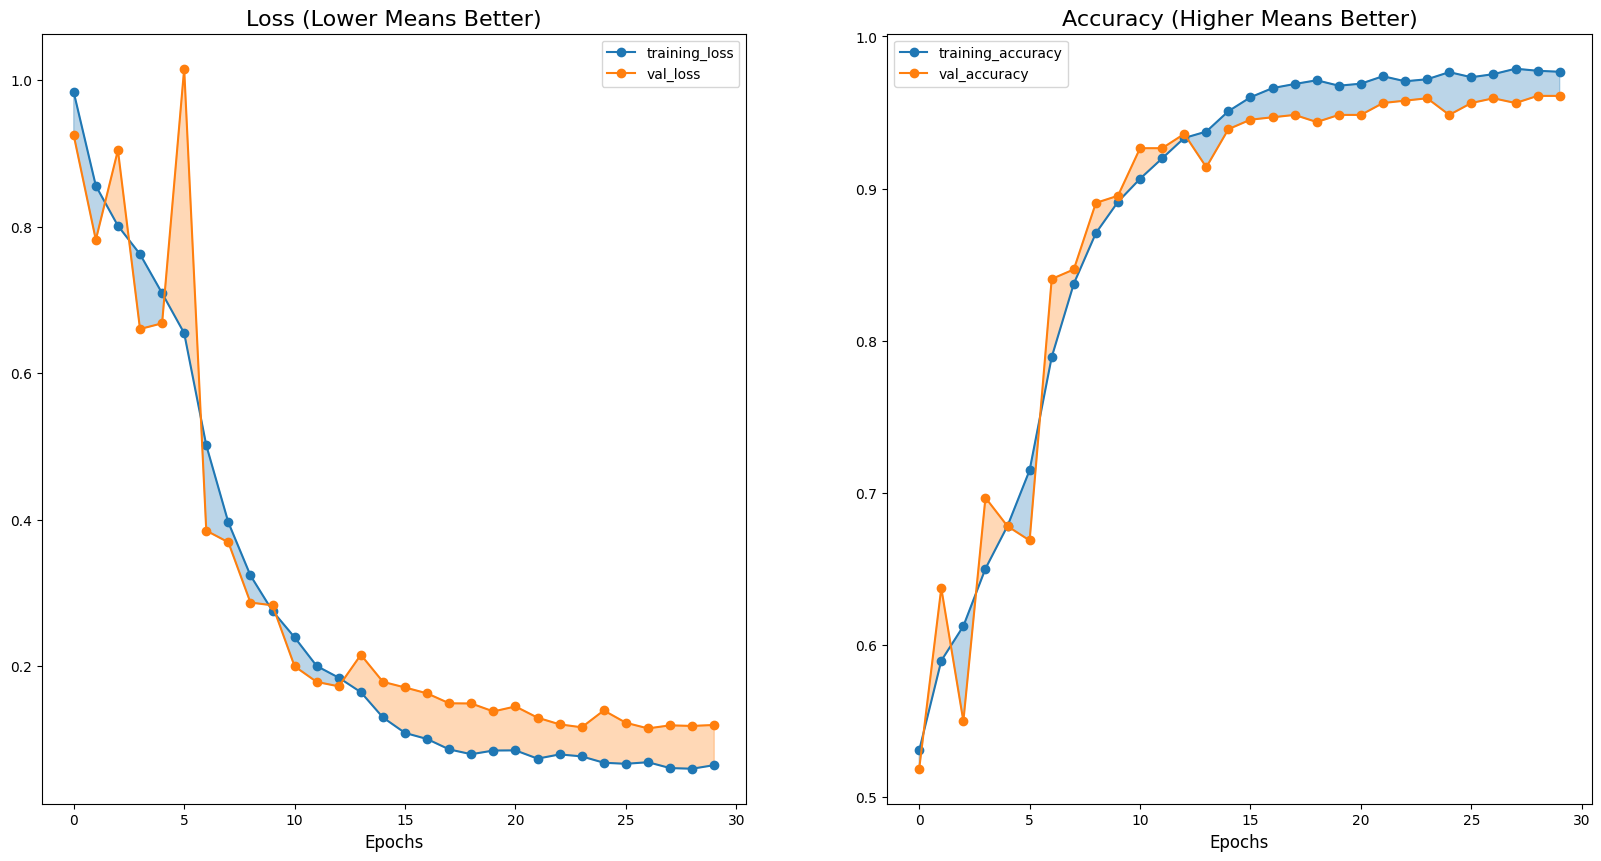

In [114]:
# Plot EfficientNet V2 B0 model training history
plot_training_curves(efficientnet_v2_history)

In [115]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

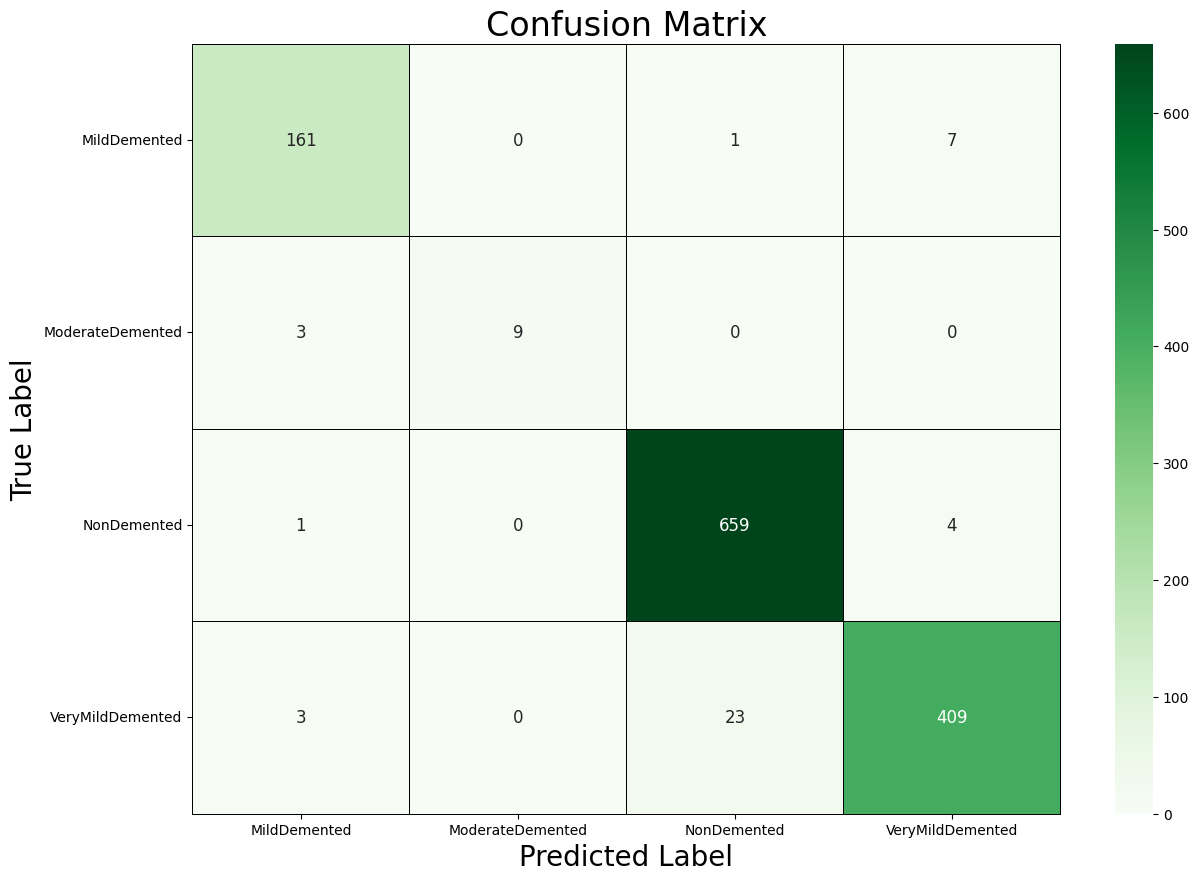

In [116]:
plot_confusion_matrix(
    test_df.label_encoded,
    efficientnet_v2_test_predictions,
    figsize=(14, 10),
    classes=class_names)

In [117]:
# EfficientNet V2 Report
print(classification_report(test_df.label_encoded,
                            efficientnet_v2_test_predictions,
                            target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.96      0.95      0.96       169
ModerateDemented       1.00      0.75      0.86        12
     NonDemented       0.96      0.99      0.98       664
VeryMildDemented       0.97      0.94      0.96       435

        accuracy                           0.97      1280
       macro avg       0.97      0.91      0.94      1280
    weighted avg       0.97      0.97      0.97      1280



In [118]:
def generate_performance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=3)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_3_accuracy': top_3_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores


In [119]:

efficientnet_v2_performance = generate_performance_scores(test_df.label_encoded,
                                                          efficientnet_v2_test_predictions,
                                                          efficientnet_v2_test_probabilities)



Performance Metrics:

accuracy_score:		0.9672

_____________________________________________
top_3_accuracy_score:	1.0000

_____________________________________________
precision_score:	0.9674

_____________________________________________
recall_score:		0.9672

_____________________________________________
f1_score:		0.9669

_____________________________________________
matthews_corrcoef:	0.9451

